# Learning without Forgetting (LwF)

LwF is a continual learning technique designed to enable a neural network to learn new tasks without forgetting previously learned ones, addressing the problem of **catastrophic forgetting**. Introduced by Li and Hoiem in their 2016 paper ([Learning without Forgetting](https://arxiv.org/abs/1606.09282)), LwF uses **knowledge distillation** to preserve knowledge from old tasks while training on new ones.

## Key Concepts
- **Old Tasks**: The model starts with knowledge of initial classes (e.g., "cow", "donkey", "sheep").
- **New Task**: A new class (e.g., "horse") is added, requiring the model to learn without losing performance on old classes.
- **Knowledge Distillation**: The model is trained to match the outputs of an old model (frozen) for old classes on new task data, using a KL divergence loss, while learning the new class with a standard cross-entropy loss.
- **Loss Function**: The total loss combines:
  \[
  L = L_{\text{new}} + \lambda \cdot L_{\text{distill}}
  \]
  where \(L_{\text{new}}\) is the cross-entropy loss for the new task, \(L_{\text{distill}}\) is the KL divergence loss for old tasks, and \(\lambda\) (denoted as `alpha`) balances the two.

## Why LwF?
LwF is suitable for scenarios where new classes are added incrementally, and retaining performance on all classes is critical, such as in image classification tasks with evolving datasets.

# Overview of Our Implementation

This notebook implements LwF to incrementally train a ResNet-18 model to classify animal images, starting with three classes ("cow", "donkey", "sheep") and adding a fourth class ("horse")

with only training on the horse dataset.
- We dont use any data of previously learned classe.
- We just update the test Dataset with new class


In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ba7d7150-d9dd-4963-521a-f75fc5568b77)


In [ ]:
pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub

# Download latest version
path_animal_ds = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path_animal_ds)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [ ]:
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(path_animal_ds)

There are 1 directories and 1 images in '/kaggle/input/animal-image-dataset-90-different-animals'.
There are 1 directories and 0 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals'.
There are 90 directories and 0 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'.
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle'.
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot'.
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/fox'.
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/wolf'.
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/hedgehog'.
There are 0 directories and 60 images in '/kaggle/input/animal-ima

In [ ]:
from typing import Dict, List, Tuple, Optional, Any, Union
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from PIL import Image

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Set device
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Define image transformations
transform: transforms.Compose = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set dataset path
data_dir: Path = Path(path_animal_ds) / "animals" / "animals"

# Define classes
initial_classes: List[str] = ['cow', 'donkey', 'sheep']
horse_class: str = 'horse'
all_classes: List[str] = initial_classes + [horse_class]

In [ ]:
# Load the full dataset
full_dataset: datasets.ImageFolder = datasets.ImageFolder(root=data_dir, transform=transform)
class_to_idx: Dict[str, int] = full_dataset.class_to_idx

# Create label mappings
initial_label_map: Dict[int, int] = {class_to_idx[cls]: i for i, cls in enumerate(initial_classes)}
incremental_label_map: Dict[int, int] = {class_to_idx[cls]: i for i, cls in enumerate(all_classes)}

In [ ]:
# Custom dataset class to map labels
class MappedDataset(Dataset):
    def __init__(self, dataset: Union[Dataset, Subset], label_map: Dict[int, int]):
        self.dataset: Union[Dataset, Subset] = dataset
        self.label_map: Dict[int, int] = label_map

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img, label = self.dataset[idx]
        mapped_label: int = self.label_map.get(label, label)
        return img, mapped_label

# Prepare initial dataset (cow, donkey, sheep)
initial_indices: List[int] = [
    i for i, (_, target) in enumerate(full_dataset.samples)
    if full_dataset.classes[target] in initial_classes
]
initial_dataset: Subset = Subset(full_dataset, initial_indices)
initial_dataset_mapped: MappedDataset = MappedDataset(initial_dataset, initial_label_map)

In [ ]:
# Split into train and validation sets
train_size: int = int(0.8 * len(initial_dataset_mapped))
val_size: int = len(initial_dataset_mapped) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(initial_dataset_mapped, [train_size, val_size])

# Prepare horse dataset for incremental learning
horse_indices: List[int] = [
    i for i, (_, target) in enumerate(full_dataset.samples)
    if full_dataset.classes[target] == horse_class
]
horse_dataset: Subset = Subset(full_dataset, horse_indices)
horse_dataset_mapped: MappedDataset = MappedDataset(horse_dataset, incremental_label_map)

# Prepare test dataset for all classes
all_indices: List[int] = [
    i for i, (_, target) in enumerate(full_dataset.samples)
    if full_dataset.classes[target] in all_classes
]
test_size: int = int(0.2 * len(all_indices))
test_indices: List[int] = random.sample(all_indices, test_size)
test_dataset: Subset = Subset(full_dataset, test_indices)
test_dataset_mapped: MappedDataset = MappedDataset(test_dataset, incremental_label_map)

In [ ]:
# Create DataLoaders
BATCH_SIZE: int = 32
NUM_WORKERS: int = os.cpu_count()

train_loader: DataLoader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)
val_loader: DataLoader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)
incremental_loader: DataLoader = DataLoader(
    horse_dataset_mapped, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)
test_loader: DataLoader = DataLoader(
    test_dataset_mapped, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

# Visualize the created DS

In [ ]:
# Verify datasets
def show_samples(
    dataset: Union[Dataset, Subset],
    class_names: List[str],
    num_samples: int = 5,
    title: str = "Dataset Samples"
) -> None:
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(min(num_samples, len(dataset))):
        img: torch.Tensor
        label: int
        img, label = dataset[i]
        img_np: np.ndarray = img.permute(1, 2, 0).numpy()  # Convert CHW to HWC
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

def count_classes(dataset: Union[Dataset, Subset], class_names: List[str], dataset_name: str = "Dataset") -> None:
    labels: List[int] = [label for _, label in dataset]
    counts: Counter = Counter(labels)
    print(f"\nClass distribution in {dataset_name}:")
    for label, count in sorted(counts.items()):
        print(f"{class_names[label]}: {count}")

Verifying horse_dataset:


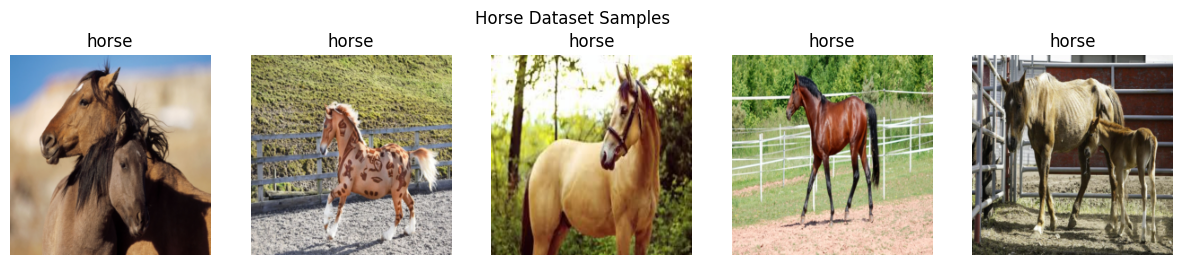


Class distribution in horse_dataset:
horse: 60

Verifying train_dataset:


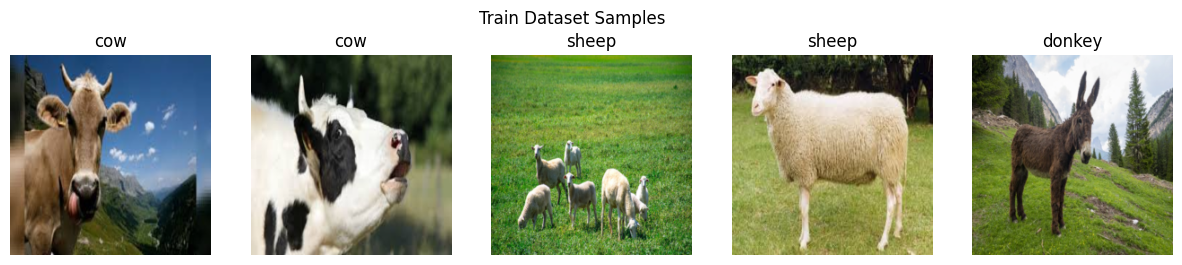


Class distribution in train_dataset:
cow: 49
donkey: 46
sheep: 49

Verifying val_dataset:


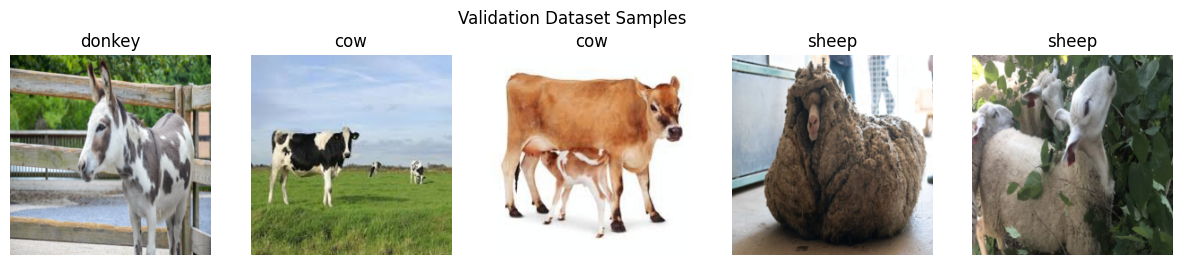


Class distribution in val_dataset:
cow: 11
donkey: 14
sheep: 11

Verifying test_dataset_mapped:


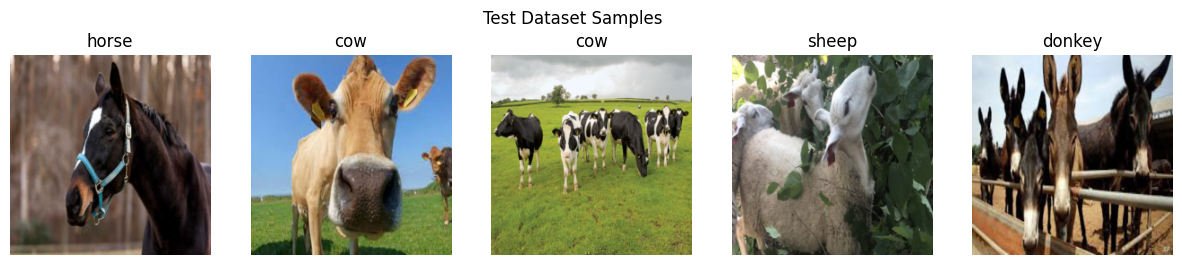


Class distribution in test_dataset_mapped:
cow: 16
donkey: 8
sheep: 13
horse: 11


In [ ]:
# Display samples and distributions
print("Verifying horse_dataset:")
show_samples(horse_dataset, full_dataset.classes, title="Horse Dataset Samples")
count_classes(horse_dataset, full_dataset.classes, "horse_dataset")

print("\nVerifying train_dataset:")
show_samples(train_dataset, initial_classes, title="Train Dataset Samples")
count_classes(train_dataset, initial_classes, "train_dataset")

print("\nVerifying val_dataset:")
show_samples(val_dataset, initial_classes, title="Validation Dataset Samples")
count_classes(val_dataset, initial_classes, "val_dataset")

print("\nVerifying test_dataset_mapped:")
show_samples(test_dataset_mapped, all_classes, title="Test Dataset Samples")
count_classes(test_dataset_mapped, all_classes, "test_dataset_mapped")

# Start model training

In [ ]:
# Define training step
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    model.train()
    train_loss: float = 0.0
    train_acc: float = 0.0
    for batch, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs: torch.Tensor = model(inputs)
        loss: torch.Tensor = loss_fn(outputs, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred_classes: torch.Tensor = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        train_acc += (pred_classes == labels).sum().item() / len(outputs)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

# Define test step
def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device: torch.device
) -> Tuple[float, float]:
    model.eval()
    test_loss: float = 0.0
    test_acc: float = 0.0
    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs: torch.Tensor = model(inputs)
            loss: torch.Tensor = loss_fn(outputs, labels)
            test_loss += loss.item()
            pred_labels: torch.Tensor = outputs.argmax(dim=1)
            test_acc += (pred_labels == labels).sum().item() / len(pred_labels)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [ ]:
# Define training step for incremental learning with LwF
def train_step_incremental(
    model: nn.Module,
    old_model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Adam,
    device: torch.device,
    alpha: float = 0.3,
    temperature: float = 2.0
) -> Tuple[float, float]:
    model.train()
    train_loss: float = 0.0
    train_acc: float = 0.0
    for batch, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs: torch.Tensor = model(inputs)
        # Classification loss for new class
        loss_ce: torch.Tensor = loss_fn(outputs, labels)
        # Distillation loss for old classes
        with torch.no_grad():
            old_outputs: torch.Tensor = old_model(inputs)
        loss_distill: torch.Tensor = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(outputs[:, :len(initial_classes)] / temperature, dim=1),
            F.softmax(old_outputs / temperature, dim=1)
        )
        # Combined loss
        loss: torch.Tensor = loss_ce + alpha * loss_distill
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred_classes: torch.Tensor = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        train_acc += (pred_classes == labels).sum().item() / len(labels)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [ ]:
# Define training function
def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: optim.Adam,
    loss_fn: nn.Module,
    epochs: int,
    device: torch.device,
    is_incremental: bool = False,
    old_model: Optional[nn.Module] = None
) -> Dict[str, List[float]]:
    results: Dict[str, List[float]] = {
        "train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []
    }
    for epoch in tqdm(range(epochs), desc="Epochs"):
        if is_incremental:
            train_loss, train_acc = train_step_incremental(
                model, old_model, train_dataloader, loss_fn, optimizer, device
            )
        else:
            train_loss, train_acc = train_step(
                model, train_dataloader, loss_fn, optimizer, device
            )
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        print(
            f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [ ]:
# Define plotting function
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [ ]:
# Initial training
model: nn.Module = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs: int = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(initial_classes))  # 3 classes initially
model.to(device)
loss_fn: nn.Module = nn.CrossEntropyLoss()
optimizer: optim.Adam = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

NUM_EPOCHS: int = 20
initial_results: Dict[str, List[float]] = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6273 | train_acc: 0.7188 | test_loss: 2.9605 | test_acc: 0.6875
Epoch: 2 | train_loss: 0.3254 | train_acc: 0.9125 | test_loss: 15.6939 | test_acc: 0.3281
Epoch: 3 | train_loss: 0.0883 | train_acc: 0.9750 | test_loss: 4.0242 | test_acc: 0.5781
Epoch: 4 | train_loss: 0.2602 | train_acc: 0.9000 | test_loss: 3.3376 | test_acc: 0.6875
Epoch: 5 | train_loss: 0.2630 | train_acc: 0.9062 | test_loss: 10.4910 | test_acc: 0.4062
Epoch: 6 | train_loss: 0.0813 | train_acc: 0.9875 | test_loss: 10.1930 | test_acc: 0.4688
Epoch: 7 | train_loss: 0.0565 | train_acc: 0.9938 | test_loss: 2.9205 | test_acc: 0.5781
Epoch: 8 | train_loss: 0.0332 | train_acc: 1.0000 | test_loss: 2.0820 | test_acc: 0.7031
Epoch: 9 | train_loss: 0.0219 | train_acc: 1.0000 | test_loss: 2.1385 | test_acc: 0.6875
Epoch: 10 | train_loss: 0.0684 | train_acc: 0.9688 | test_loss: 1.5162 | test_acc: 0.7969
Epoch: 11 | train_loss: 0.0465 | train_acc: 0.9875 | test_loss: 0.7641 | test_acc: 0.8281
Epoch: 12 | trai

In [ ]:
# Save initial model
torch.save(model.state_dict(), 'model_initial.pth')

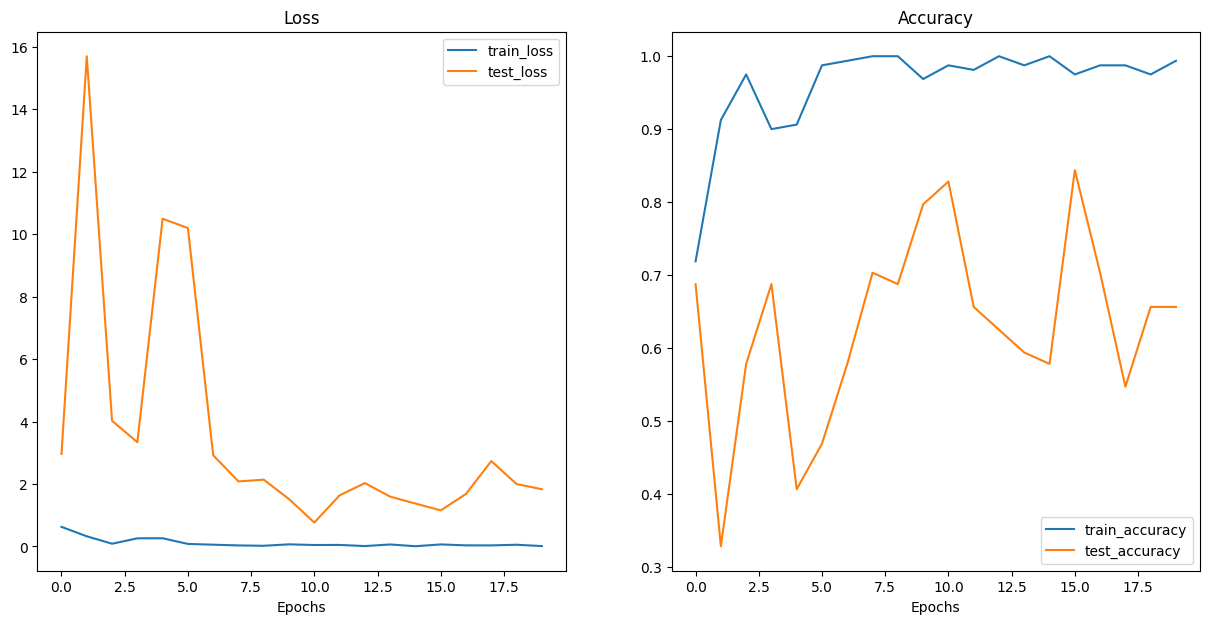

In [ ]:
# Plot initial results
plot_loss_curves(initial_results)

# Lets add horse (increment classes/add new class) detection to our model

In [ ]:
# Load old model for distillation
old_model: nn.Module = models.resnet18(weights=ResNet18_Weights.DEFAULT)
old_model.fc = nn.Linear(num_ftrs, len(initial_classes))
old_model.load_state_dict(torch.load('model_initial.pth', map_location=device))
old_model.to(device)
old_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Modify model for incremental learning (4 classes)
model.fc = nn.Linear(num_ftrs, len(all_classes))
# Copy weights for old classes to prevent forgetting
model.fc.weight.data[:len(initial_classes)] = old_model.fc.weight.data
model.fc.bias.data[:len(initial_classes)] = old_model.fc.bias.data
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Lowered learning rate

In [ ]:
# Incremental training with LwF
NUM_EPOCHS_INCREMENTAL: int = 10
incremental_results: Dict[str, List[float]] = train(
    model=model,
    train_dataloader=incremental_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS_INCREMENTAL,
    device=device,
    is_incremental=True,
    old_model=old_model
)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8064 | train_acc: 0.0000 | test_loss: 0.9452 | test_acc: 0.7656
Epoch: 2 | train_loss: 3.6223 | train_acc: 0.0000 | test_loss: 0.8156 | test_acc: 0.7969
Epoch: 3 | train_loss: 2.8102 | train_acc: 0.0670 | test_loss: 0.7193 | test_acc: 0.7969
Epoch: 4 | train_loss: 2.3892 | train_acc: 0.1183 | test_loss: 0.5886 | test_acc: 0.8125
Epoch: 5 | train_loss: 1.8208 | train_acc: 0.2746 | test_loss: 0.4963 | test_acc: 0.8281
Epoch: 6 | train_loss: 1.5053 | train_acc: 0.4844 | test_loss: 0.4301 | test_acc: 0.7969
Epoch: 7 | train_loss: 1.2157 | train_acc: 0.5737 | test_loss: 0.3647 | test_acc: 0.8125
Epoch: 8 | train_loss: 0.9419 | train_acc: 0.7969 | test_loss: 0.2974 | test_acc: 0.8594
Epoch: 9 | train_loss: 0.7742 | train_acc: 0.8549 | test_loss: 0.2525 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.6275 | train_acc: 0.9330 | test_loss: 0.2366 | test_acc: 0.9531


In [ ]:
# Save final model
torch.save(model.state_dict(), 'model_all_animals.pth')

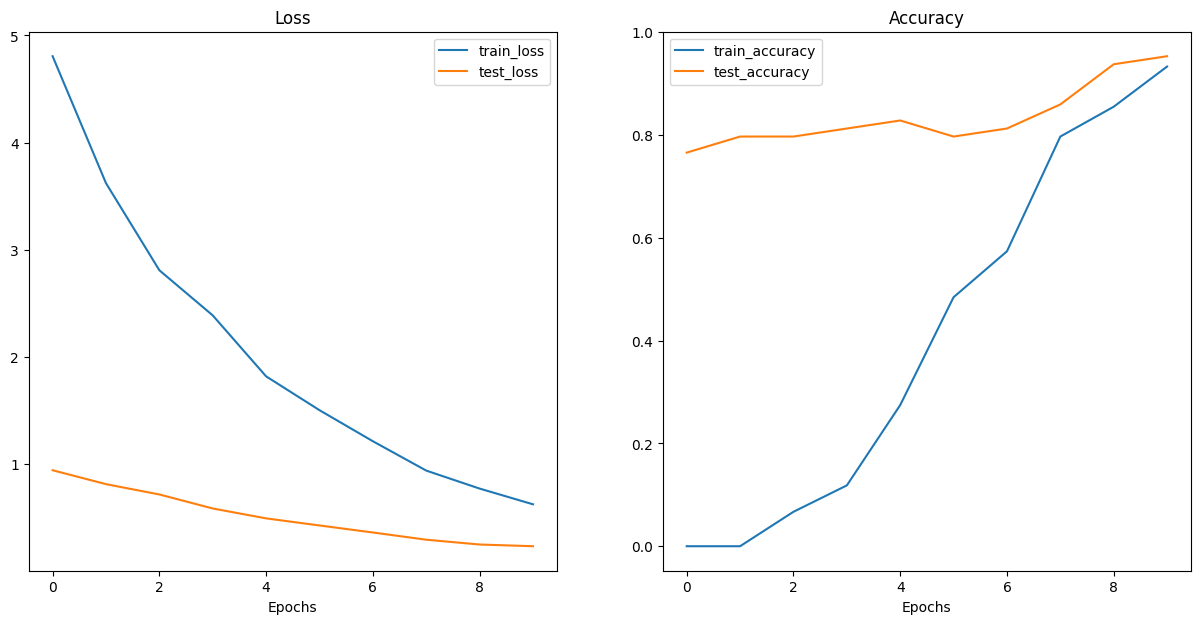

In [ ]:
# Plot incremental results
plot_loss_curves(incremental_results)

# Evaluate the Final model with 4 classes

In [ ]:
# Evaluate the model on the test set
def evaluate_model(model: nn.Module, dataloader: DataLoader, class_names: List[str]) -> None:
    model.eval()
    all_preds: List[int] = []
    all_labels: List[int] = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs: torch.Tensor = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm: np.ndarray = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [ ]:
print("\nEvaluating model on test set after incremental training:")
evaluate_model(model, test_loader, all_classes)


Evaluating model on test set after incremental training:

Confusion Matrix:
[[15  0  0  1]
 [ 0  8  0  0]
 [ 0  0 13  0]
 [ 0  0  1 10]]

Classification Report:
              precision    recall  f1-score   support

         cow       1.00      0.94      0.97        16
      donkey       1.00      1.00      1.00         8
       sheep       0.93      1.00      0.96        13
       horse       0.91      0.91      0.91        11

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



In [ ]:
all_classes

['cow', 'donkey', 'sheep', 'horse']

In [ ]:
transform, device

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 device(type='cuda'))

# Predict on Unseen Data

In [ ]:
# Prediction function for a single image
def predict_and_display_image(
    image_path: Union[str, Path],
    model: nn.Module = model,
    class_names: List[str] = all_classes,
    transform: transforms.Compose = transform,
    device: torch.device = device
) -> Tuple[str, float]:
    image: Image.Image = Image.open(image_path).convert('RGB')
    image_tensor: torch.Tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output: torch.Tensor = model(image_tensor)
        probabilities: torch.Tensor = torch.softmax(output, dim=1)[0]
        predicted_class_idx: int = torch.argmax(probabilities).item()
        predicted_class: str = class_names[predicted_class_idx]
        confidence: float = probabilities[predicted_class_idx].item()
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} ({confidence:.4f})")
    plt.axis('off')
    plt.show()
    print("\nPrediction Probabilities for All Classes:")
    for cls, prob in zip(class_names, probabilities):
        print(f"{cls}: {prob.item():.4f}")
    print(f"\nPredicted Animal: {predicted_class}")
    print(f"Confidence Score: {confidence:.4f}")
    return predicted_class, confidence

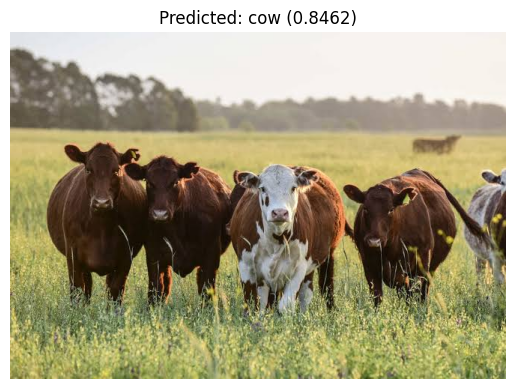


Prediction Probabilities for All Classes:
cow: 0.8462
donkey: 0.0002
sheep: 0.0035
horse: 0.1501

Predicted Animal: cow
Confidence Score: 0.8462


('cow', 0.846206784248352)

In [ ]:
predict_and_display_image('/content/images (4).jpeg')

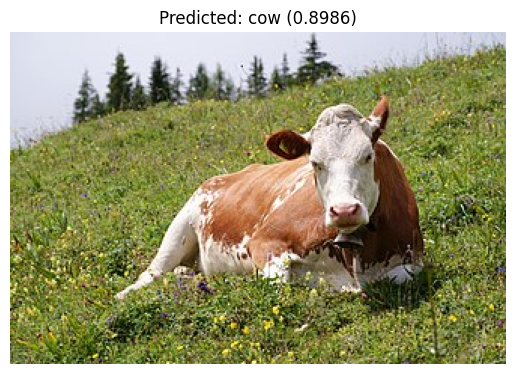


Prediction Probabilities for All Classes:
cow: 0.8986
donkey: 0.0002
sheep: 0.0016
horse: 0.0997

Predicted Animal: cow
Confidence Score: 0.8986


('cow', 0.898589015007019)

In [ ]:
predict_and_display_image('/content/Cow_(Fleckvieh_breed)_Oeschinensee_Slaunger_2009-07-07.jpg')

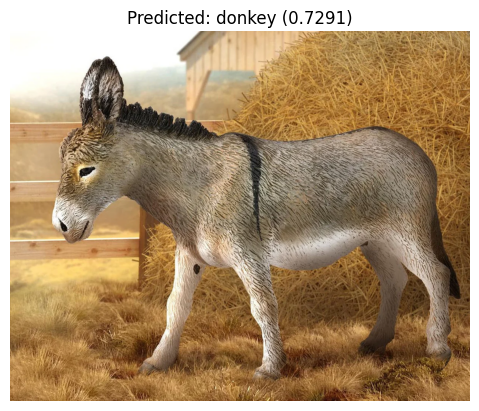


Prediction Probabilities for All Classes:
cow: 0.0026
donkey: 0.7291
sheep: 0.0474
horse: 0.2209

Predicted Animal: donkey
Confidence Score: 0.7291


('donkey', 0.7291418313980103)

In [ ]:
predict_and_display_image('/content/donkey-model-breyer-603193_1200x966.webp')

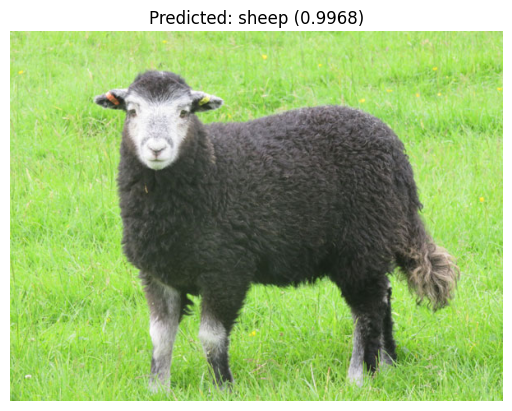


Prediction Probabilities for All Classes:
cow: 0.0001
donkey: 0.0000
sheep: 0.9968
horse: 0.0031

Predicted Animal: sheep
Confidence Score: 0.9968


('sheep', 0.996828019618988)

In [ ]:
predict_and_display_image('/content/herdwick-lamb-full-body.jpg')

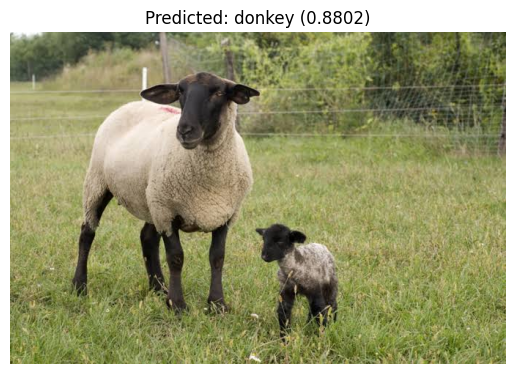


Prediction Probabilities for All Classes:
cow: 0.0006
donkey: 0.8802
sheep: 0.0090
horse: 0.1102

Predicted Animal: donkey
Confidence Score: 0.8802


('donkey', 0.8801894783973694)

In [ ]:
predict_and_display_image('/content/images (1).jpeg')

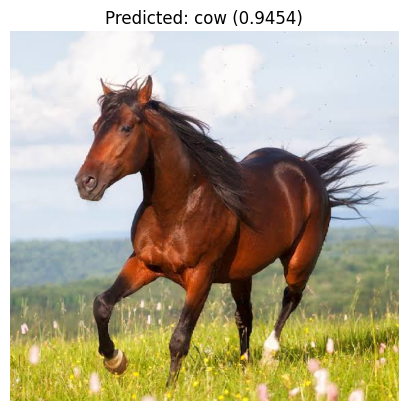


Prediction Probabilities for All Classes:
cow: 0.9454
donkey: 0.0004
sheep: 0.0001
horse: 0.0541

Predicted Animal: cow
Confidence Score: 0.9454


('cow', 0.9453940391540527)

In [ ]:
predict_and_display_image('/content/images.jpeg')

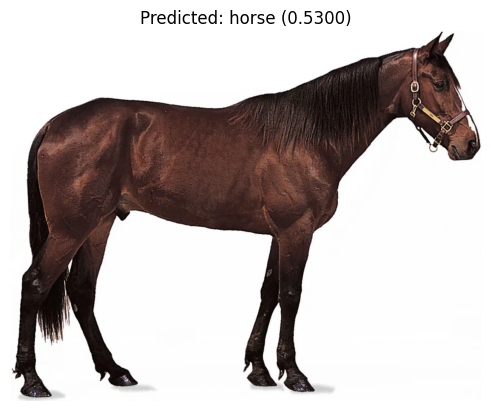


Prediction Probabilities for All Classes:
cow: 0.4010
donkey: 0.0601
sheep: 0.0089
horse: 0.5300

Predicted Animal: horse
Confidence Score: 0.5300


('horse', 0.5299957990646362)

In [ ]:
predict_and_display_image('/content/gelding-bay-coat.webp')

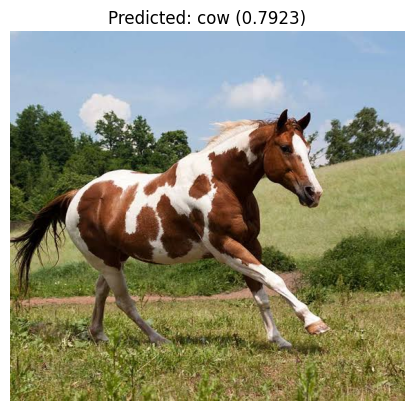


Prediction Probabilities for All Classes:
cow: 0.7923
donkey: 0.0010
sheep: 0.0047
horse: 0.2019

Predicted Animal: cow
Confidence Score: 0.7923


('cow', 0.7923441529273987)

In [ ]:
predict_and_display_image('/content/images (2).jpeg')

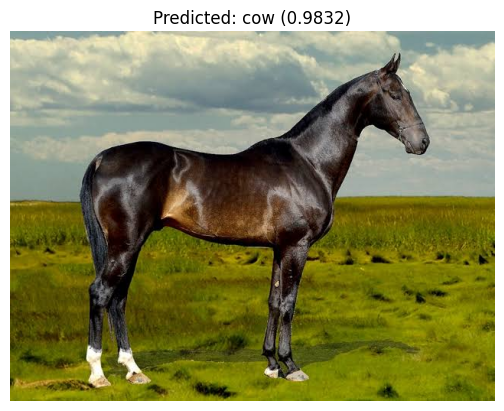


Prediction Probabilities for All Classes:
cow: 0.9832
donkey: 0.0000
sheep: 0.0000
horse: 0.0168

Predicted Animal: cow
Confidence Score: 0.9832


('cow', 0.9831815361976624)

In [ ]:
predict_and_display_image('/content/images (3).jpeg')